# DESI PV Y3 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **May 20, 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

Changes I am adding:
- Adding $V_{max}$ weighting
- Implementing coordinate corrections
- Adjusting cluster membership

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Jura Data

In [3]:
sgatab_sel = Table.read('SGA-2020_jura_Vrot_VI_ML_photocorr.fits')
sgatab_sel[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,R_ABSMAG_SB26_CORR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10
32,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA Jura observations that have passed all quality cuts.

In [4]:
zeroptab = Table.read('SGA-2020_jura_Vrot_VI_0ptPRIMARY_calib_z0p1.fits')

use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

# Access Williams Cluster Catalog

These groups come from the group catalog being created by Ian Williams, still a work in progress as of April 2025. The cluster membership is explicity defined in this catalog

In [5]:
clusters = Table.read('/global/cfs/cdirs/desi/users/ianw89/groupcatalogs/BGS_DR1/WIP/GROUP_CATALOG_BGS_DR1_vWIP.fits')
print(len(clusters), 'galaxies')
clusters[:5]

2026991 galaxies


TARGETID,RA,DEC,Z,L_GAL,VMAX,P_SAT,M_HALO,N_SAT,L_TOT,IGRP,WEIGHT,APP_MAG_R,Z_ASSIGNED_FLAG,G_R,IS_SAT,QUIESCENT,MSTAR
,deg,deg,,solLum,Mpc3,,solMass,,solLum,,,,,,,,solMass
int64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int64,float64,float64,int32,float64,bool,bool,float64
39627380670601556,55.902303,-16.884476,0.162567,4764775000.0,55698820.0,0.0,505817600000.0,0,4764775000.0,0,1.0,19.017427444458008,0,1.0929977643790885,False,True,25693734513.535473
39627380674790280,55.944535,-16.893928,0.379525,35850470000.0,402659800.0,0.0,9347829000000.0,0,35850470000.0,1,1.0,19.323333740234375,0,0.47180674025630864,False,False,88492617964.93707
39627380674790571,55.957236,-16.879536,0.10111,5480330000.0,92092950.0,0.0,576773400000.0,0,5480330000.0,2,1.0,17.64963150024414,0,1.0564885097731391,False,True,87984761893.22266
39627380674790613,55.959407,-16.917764,0.146161,3413083000.0,36388860.0,0.0,366888100000.0,0,3413083000.0,3,1.0,19.101951599121094,0,0.9458895361494228,False,True,53512067260.690765
39627380674791557,56.002231,-16.912539,0.2482,9533217000.0,106265300.0,0.0,1071110000000.0,0,9533217000.0,4,1.0,19.429059982299805,0,0.9826355566013198,False,True,45169792837.12422


# Find Group Membership
Each galaxy in the Williams catalog is assigned to a group. So, we just need to match our galaxies to those in the Williams catalog. We perform this matching using the targetids in `Catalog_Matching_Williams.ipynb`, so we can read in the file that contains the groups corresponding to each of our SGA_IDs, and then append this to our table.

In [6]:
target_matches = Table.read('Jura_Williams_TargetID_Matches.fits')

sgatab = join(target_matches, sgatab_sel, keys='SGA_ID', join_type='inner')

## rename the group ids for consistency later
sgatab['CLUSTER_ID'] = sgatab['IGRP']
sgatab['SGA_ID', 'RA', 'DEC', 'D26','CLUSTER_ID'][:5]

SGA_ID,RA,DEC,D26,CLUSTER_ID
int64,float64,float64,float32,int64
38,211.66203166014844,39.52724032794356,0.41757938,1726821
55,199.73062047638814,1.7262730115560398,0.4956815,770280
117,138.9354018819327,2.69476220880469,0.56725013,850977
424,174.87280864038723,64.51490876098275,0.6987798,1942591
1158,162.9365776212831,3.099621278249546,0.78353685,874776


Let's get a sense of how large our groups are.

In [7]:
group, grp_count = np.unique(sgatab['CLUSTER_ID'], return_counts = True)
print('3+ galaxies:', np.sum(grp_count >= 3))
print('5+ galaxies:', np.sum(grp_count >= 5))
print('8+ galaxies:', np.sum(grp_count >= 8))
print('10+ galaxies:', np.sum(grp_count >= 10))

3+ galaxies: 15
5+ galaxies: 3
8+ galaxies: 1
10+ galaxies: 1


# Find Clusters with at least 8 Galaxies

In [8]:
#### only keep clusters with at least 8 gals
sga_groups = {
    group[i]: list(sgatab['SGA_ID'][sgatab['CLUSTER_ID'] == group[i]])
    for i in range(len(group))
    if grp_count[i] >= 10
}

In [9]:
#### print out the good clusters and their counts
for i, (cluster_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  740551  10 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

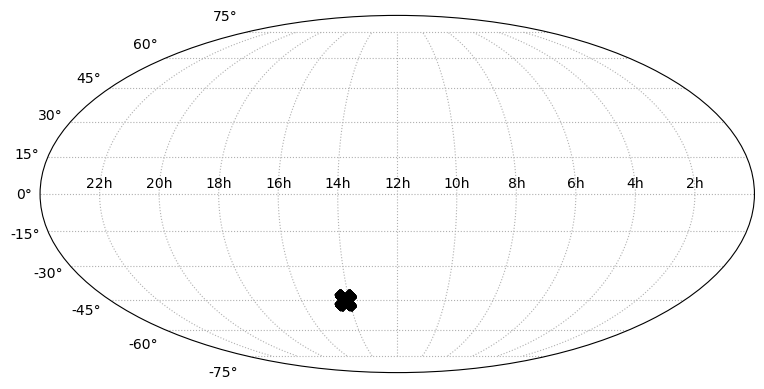

In [10]:
nest_ids = np.asarray(list(sga_groups.keys()))
idx = np.in1d(clusters['IGRP'], nest_ids)
cluster_lon = clusters['RA'][idx]
cluster_lat = clusters['DEC'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);


In [11]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [12]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    # Get Williams cluster members (full set)
    idx_williams = np.in1d(clusters['IGRP'], cluster_id)
    cluster_galaxies = clusters[idx_williams]
    cluster_coord = SkyCoord(ra=cluster_galaxies['RA'], dec=cluster_galaxies['DEC'], unit='deg', frame='icrs')

    
    z_cluster = clusters['Z'][idx_williams]
    z_sort_williams = np.sort(z_cluster)
    n_gal = len(z_sort_williams)
    z_cluster_median = np.mean(z_sort_williams[n_gal//2:n_gal//2 + 2]) if (n_gal % 2 == 0) else z_sort_williams[n_gal//2]
    
    cluster_coords_median = cluster_median_coords(cluster_coord)

    # Get observed (SGAcat) galaxies for this cluster (subset)
    idx_sga = np.in1d(sgacat['CLUSTER_ID'], cluster_id)
    
    z_sga = sgacat['Z_DESI'][idx_sga]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    
    sga_subset = sgacat[idx_sga]
    sga_coords = SkyCoord(ra=sga_subset['RA'], dec=sga_subset['DEC'], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    # Calculate angular distances from cluster center for both catalogs
    separations_williams = cluster_coord.separation(sga_coords_median)
    separations_sga = sga_coords.separation(sga_coords_median)

    # Determine max radius to cover all galaxies in both catalogs
    max_sep_williams = np.max(separations_williams) if len(separations_williams) > 0 else 0
    max_sep_sga = np.max(separations_sga) if len(separations_sga) > 0 else 0
    radius = max(max_sep_williams, max_sep_sga)

    # Plot
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=sga_coords_median, radius=1.2*radius)
    ax.grid()

    # Plot all Williams galaxies
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, '.', color='blue',
            transform=ax.get_transform('world'), alpha=0.2, label='Williams catalog')

    # Plot observed galaxies
    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', color='green',
            transform=ax.get_transform('world'), alpha=0.8, label='Observed (SGAcat)', zorder=10)

    # Mark cluster center and sga center
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD',
            transform=ax.get_transform('world'), ms=8, mew=2)
    ax.plot(cluster_coords_median.ra.deg, cluster_coords_median.dec.deg, 'kx',
            transform=ax.get_transform('world'), ms=8, mew=2)

    # Circle showing extent of the cluster
    circle = SphericalCircle(sga_coords_median, radius, transform=ax.get_transform('world'),
                             edgecolor='tab:green', linestyle='dashed', facecolor='none')
    ax.add_patch(circle)

    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    # ax.legend()


    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_cluster, cluster_coord.dec.deg, '.', color='blue', alpha=0.2, label=f'{cluster_id}')
    ax.plot(z_sga, sga_coords.dec.deg, 'o', color='green', alpha=0.8, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(z_cluster_median, cluster_coords_median.dec.deg, 'kx', ms=5, mew=5)
    
    # ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = min(np.min(cluster_coord.dec.deg), np.min(sga_coords.dec.deg) ) - 0.5
    decmax = max(np.max(cluster_coord.dec.deg), np.max(sga_coords.dec.deg) ) + 0.5

    # ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
    #                       cluster_v+3*cluster_sigma,
    #                       cluster_v-2*cluster_sigma,
    #                       cluster_v+2*cluster_sigma])/c_kms,
    #           decmin, decmax,
    #           colors='tab:blue',
    #           linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(cluster_coord.ra.deg, z_cluster, '.', color='blue', alpha=0.2, label=f'{cluster_id}')
    ax.plot(sga_coords.ra.deg, z_sga, 'o', color='green', alpha=0.8, label=f'{cluster_id}')    
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coords_median.ra.deg, z_cluster_median, 'kX', ms=5, mew=5)
    # ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = min(np.min(cluster_coord.ra.deg), np.min(sga_coords.ra.deg) ) - 0.5
    ramax = max(np.max(cluster_coord.ra.deg), np.max(sga_coords.ra.deg) ) + 0.5

    # ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
    #                       cluster_v+3*cluster_sigma,
    #                       cluster_v-2*cluster_sigma,
    #                       cluster_v+2*cluster_sigma])/c_kms,
    #           ramin, ramax,
    #           colors='tab:blue',
    #           linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.25
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    # ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    # ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.001
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    # ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Jura Observations of Williams Group {cluster_id}')

    return fig

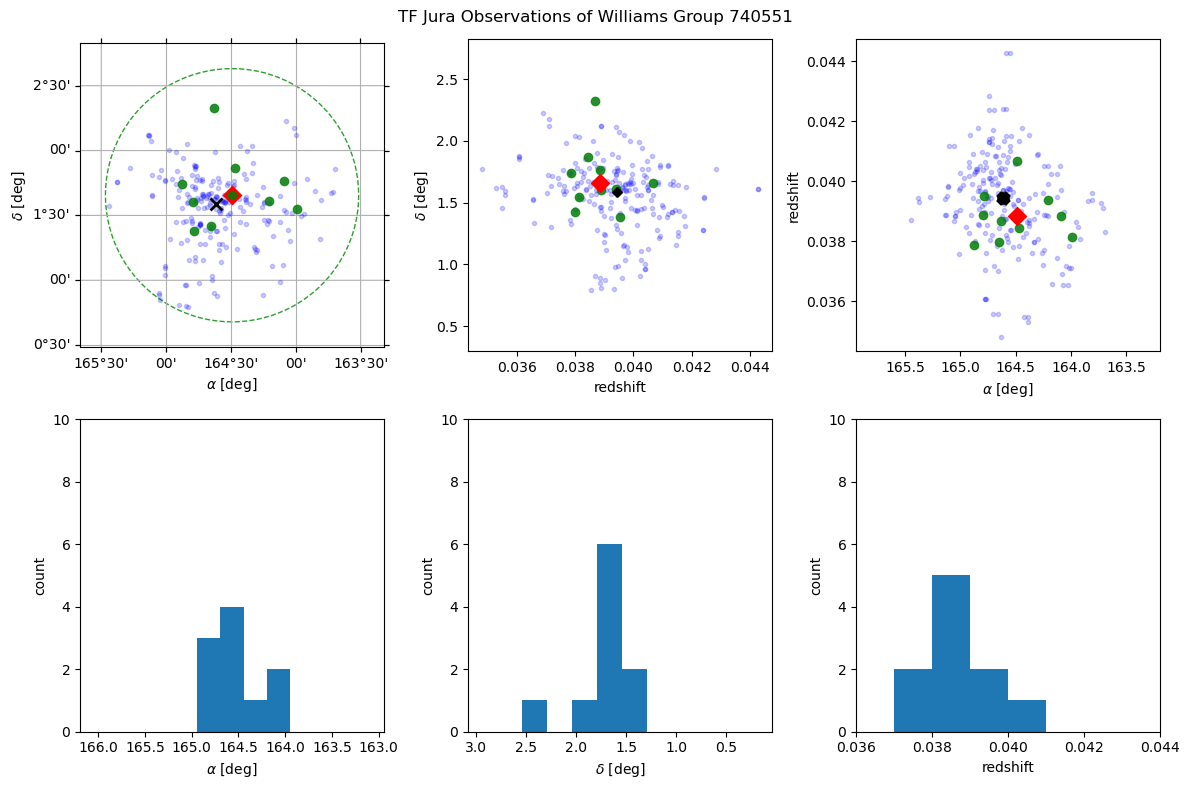

In [13]:
for cluster_id in sga_groups.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab, sga_groups[cluster_id])

# Apply Cluster Selection

For now, our one object looks reasonable, so we're just going to keep it.

In [14]:
# keep_cluster = []
# dv_sigmaV = []
# dtheta_R2t = []
# cluster_ids = []

# for cluster_id, sga_ids in sga_clusters.items():
#     #- Get cluster sky coordinates
#     idx = np.in1d(clusters['Nest'], cluster_id)
#     cluster_lon = clusters['SGLON'][idx][0]
#     cluster_lat = clusters['SGLAT'][idx][0]
#     cluster_v = 100 * 10**(0.2*(clusters['DM'][idx][0] - 25)) / (1 + clusters['HRV'][idx][0]/c_kms)
#     cluster_sigma = clusters['sigV'][idx][0]
#     cluster_R2t = clusters['R2t'][idx][0]
#     cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
#     cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
#     cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
#     cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
#     cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
#     #- Get SGA galaxy coordinates and median of observations
#     idx = np.in1d(sgatab['SGA_ID'], sga_ids)
#     z_sga = sgatab['Z_DESI'][idx]
#     z_sorted = np.sort(z_sga)
#     ngal = len(z_sorted)
#     z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
#     sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
#     sga_coords_median = cluster_median_coords(sga_coords)

#     #- Compute the angle and velocity ratios:
#     delta_v = cluster_v - c_kms*z_sga_median
#     _dv_sigV = delta_v / cluster_sigma
#     dv_sigmaV.append(_dv_sigV)

#     delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
#     _dth_R2t = delta_theta / cluster_R2t_angle
#     dtheta_R2t.append(_dth_R2t)

#     cluster_ids.append(cluster_id)

#     #- Print results:
#     print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
#           f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

# dv_sigmaV = np.asarray(dv_sigmaV)
# dtheta_R2t = np.asarray(dtheta_R2t)
# cluster_ids = np.asarray(cluster_ids)

# #- Apply selection
# dvcut = 1
# dthcut = 1

# select = (np.abs(dv_sigmaV) < dvcut) & (dtheta_R2t < dthcut)

# #- Plot results

# fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
# ax = axes[0]
# ax.scatter(dv_sigmaV[select], dtheta_R2t[select], color='g')
# for _dv, _dth, _id in zip(dv_sigmaV[select], dtheta_R2t[select], cluster_ids[select]):
#     ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

# ax.scatter(dv_sigmaV[~select], dtheta_R2t[~select], color='r')
# for _dv, _dth, _id in zip(dv_sigmaV[~select], dtheta_R2t[~select], cluster_ids[~select]):
#     ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

# ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
# ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
# ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
# ax.set(xlabel=r'$\Delta v/\sigma_V$',
#        xlim=(-1.5, 1.5),
#        ylabel=r'$\Delta\theta/R_{2t}$',
#        ylim=(0,2))

# ax = axes[1]
# ax.scatter(np.abs(dv_sigmaV[select]), dtheta_R2t[select], color='g')
# for _dv, _dth, _id in zip(np.abs(dv_sigmaV[select]), dtheta_R2t[select], cluster_ids[select]):
#     ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

# ax.scatter(np.abs(dv_sigmaV[~select]), dtheta_R2t[~select], color='r')
# for _dv, _dth, _id in zip(np.abs(dv_sigmaV[~select]), dtheta_R2t[~select], cluster_ids[~select]):
#     ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

# ax.axvline(dvcut, ls=':', color='k')
# ax.axvline(-dvcut, ls=':', color='k')
# ax.axhline(dthcut, ls=':', color='k')
# ax.set(xlabel=r'$|\Delta v|/\sigma_V$',
#        xlim=(0, 1.5));


In [15]:
# nest_ids = np.asarray(list(sga_clusters.keys()))
# good_idx = np.in1d(clusters['Nest'], nest_ids[select])
# bad_idx = np.in1d(clusters['Nest'], nest_ids[~select])
# good_cluster_coords = SkyCoord(clusters['SGLON'][good_idx], clusters['SGLAT'][good_idx], unit='deg', frame='supergalactic')
# bad_cluster_coords = SkyCoord(clusters['SGLON'][bad_idx], clusters['SGLAT'][bad_idx], unit='deg', frame='supergalactic')

# ax = init_sky()

# ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
#            ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
#            marker='x', 
#            s=100,
#            linewidth=2,
#            color='gray', 
#            label='rejected clusters')
# ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
#            ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
#            marker='x', 
#            s=100,
#            linewidth=5,
#            color='black', 
#            label='DESI DR1')

# ax.xaxis.label.set_size(14)
# ax.yaxis.label.set_size(14)

# plt.legend(loc='lower right')

# plt.tick_params(axis='both', which='major', labelsize=12);

# # plt.savefig('../../Figures/Y1/iron_clusters_AnthonyUpdates_sky.png', dpi=150, facecolor='none');

In [16]:
# for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
#     print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

## Plot Clusters that Failed

In [17]:
# for cluster_id in sga_clusters.keys():
#     if cluster_id in cluster_ids[~select]:
#         fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
#         # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Clusters that Passed

In [18]:
# for cluster_id in sga_clusters.keys():
#     if cluster_id in cluster_ids[select]:
#         fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
#         # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [19]:
# caltab = None    # Table of selected clusters and SGA galaxies
# rejtab = None    # Table of clusters failing the selection

# for cluster_id, sga_ids in sga_clusters.items():
#     if cluster_id in cluster_ids[select]:
#         idx = np.in1d(sgatab['SGA_ID'], sga_ids)
#         clustertab = sgatab[idx]
#         clustertab['CLUSTER_ID'] = cluster_id
        
#         caltab = clustertab if caltab is None else vstack([caltab, clustertab])
#     else:
#         idx = np.in1d(sgatab['SGA_ID'], sga_ids)
#         clustertab = sgatab[idx]
#         clustertab['CLUSTER_ID'] = cluster_id
        
#         rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

# # caltab.write('SGA-2020_jura_Vrot_cluster_calib_VI_full_sample.fits', overwrite=True)
# caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

In [20]:
# For if we are just keeping the one 
caltab = sgatab[sgatab['CLUSTER_ID'] == 740551]
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

CLUSTER_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_err
int64,int64,float64,float64,float64,float64
740551,323581,14.928427969333717,0.16150483183538306,177.55287307779483,3.2605472575783865
740551,580774,15.650612440668045,0.06937743543663218,111.797790605644,1.1526675132875355
740551,660254,15.157533949036152,0.08425849941291612,163.63691081534887,1.2499922439541138
740551,837825,16.226780887059867,0.1476516960156622,74.28435393295969,4.12328923774541
740551,849224,15.388808850487694,0.10073038513294727,110.97842420085786,1.377952239002247
740551,900159,14.96774868951179,0.08438666253031114,120.13123714694439,4.385853683246706
740551,1142913,14.159948158739134,0.17300334754850252,260.0551723158207,45.682251231002226
740551,1171905,14.667969408091158,0.130115442728678,28.728518464985868,14.08982344769111
740551,1209948,14.396570836305619,0.16220218200844394,153.01738124629006,10.544795174406653


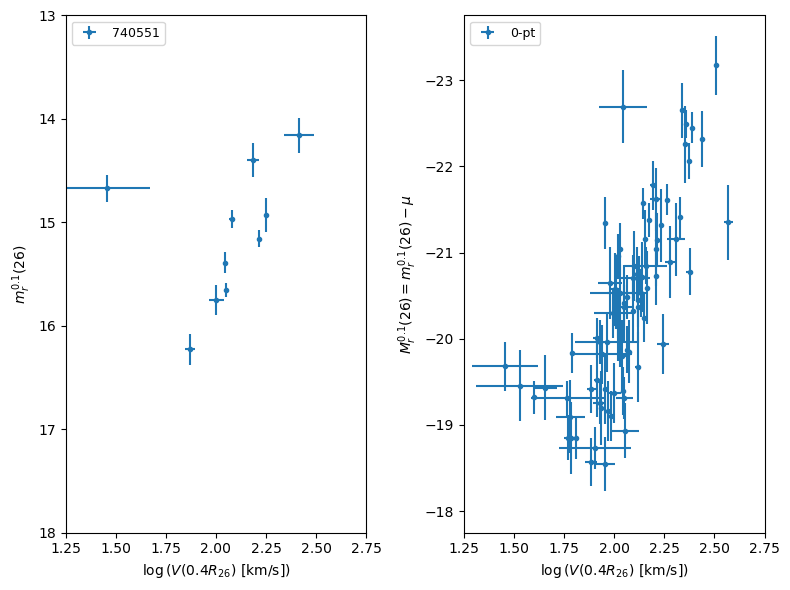

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

# #- Plot galaxies with failed cluster selections.
# _cluster_ids = np.unique(rejtab['CLUSTER_ID'])
# markers = 'sDv^<>'
# for j, _cluster_id in enumerate(_cluster_ids):
#     select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

#     #- Store independent variable for each cluster
#     logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
#     logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

#     #- Store dependent variable for each cluster
#     mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
#     mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
#     ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
#                 fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# # fig.savefig('Figures/TF_Y3_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [22]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_cluster]))

logV0 = 2.0503909486890404


In [23]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -10920.22322502728
     jac: array([ 0.03110472, -0.01800799, -0.04729372,  0.01618901])
 message: 'Optimization terminated successfully.'
    nfev: 2875
     nit: 46
 success: True
       x: array([ -6.97239902, -20.2451581 ,  15.54505527,   0.69742183])
Ndim: 4 2


100%|██████████| 1000/1000 [00:02<00:00, 430.39it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.268772   37.11114409 42.85896067 41.74709741] / 2142.948033450031


100%|██████████| 1000/1000 [00:02<00:00, 469.24it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.37560235 37.94082088 41.14841311 42.46288026] / 2168.780117538407


100%|██████████| 1000/1000 [00:02<00:00, 464.81it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.09676657 38.31090696 39.95094189 52.43513459] / 2621.756729583028


100%|██████████| 1000/1000 [00:02<00:00, 446.68it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.57169852 50.3246437  39.31394888 49.65772118] / 2516.2321847996236


100%|██████████| 1000/1000 [00:02<00:00, 459.82it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.33930603 43.50833668 35.08270406 46.81334143] / 2340.66707160363


100%|██████████| 1000/1000 [00:02<00:00, 465.55it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.89177727 50.04940125 39.33861563 47.084838  ] / 2502.470062323726


100%|██████████| 1000/1000 [00:02<00:00, 470.52it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.36255104 46.69082076 40.5571459  42.55103434] / 2334.5410381468196


100%|██████████| 1000/1000 [00:02<00:00, 460.31it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.79260653 42.90011331 47.39124103 44.93098787] / 2369.5620515053447


100%|██████████| 1000/1000 [00:02<00:00, 462.64it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.08101519 42.70512871 45.30931075 44.05899989] / 2265.465537394121


100%|██████████| 1000/1000 [00:02<00:00, 451.52it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.90053488 43.93973643 47.57182365 44.63233065] / 2378.5911822627177


In [24]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_williams.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

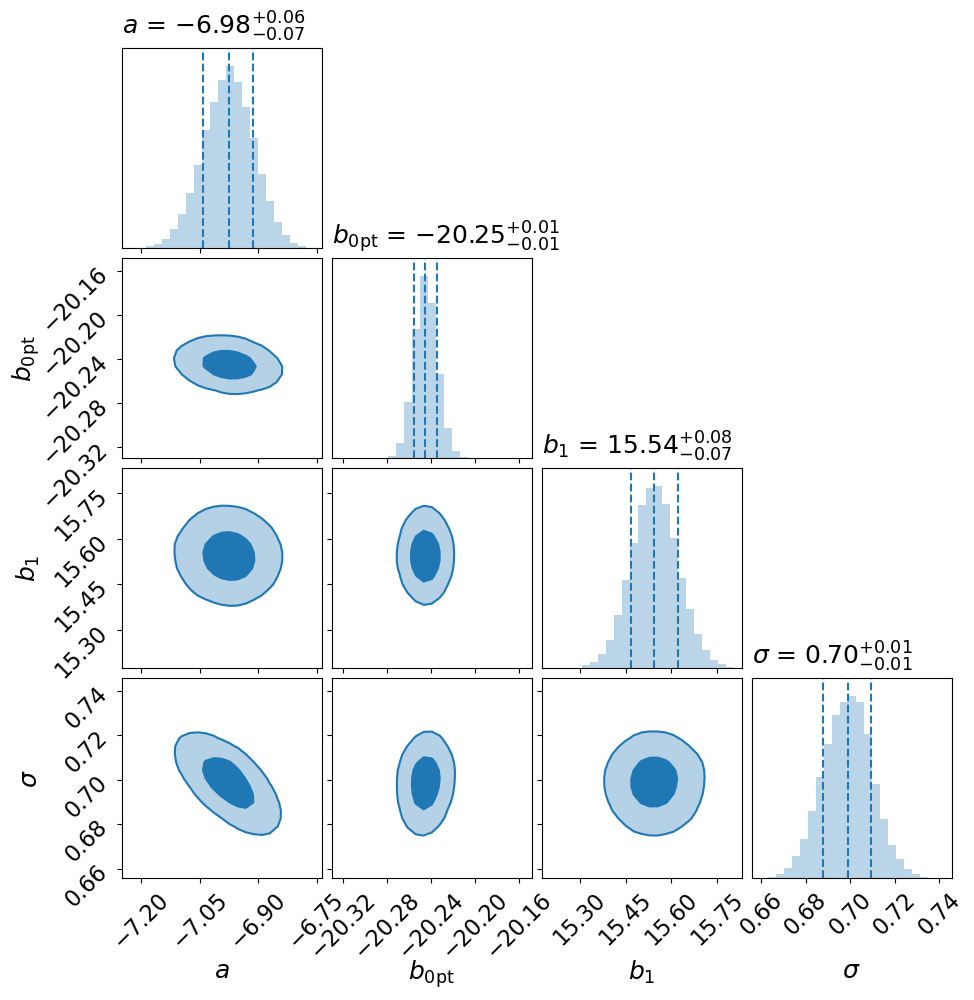

In [25]:
### Full corner plot
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1.png', dpi=150);

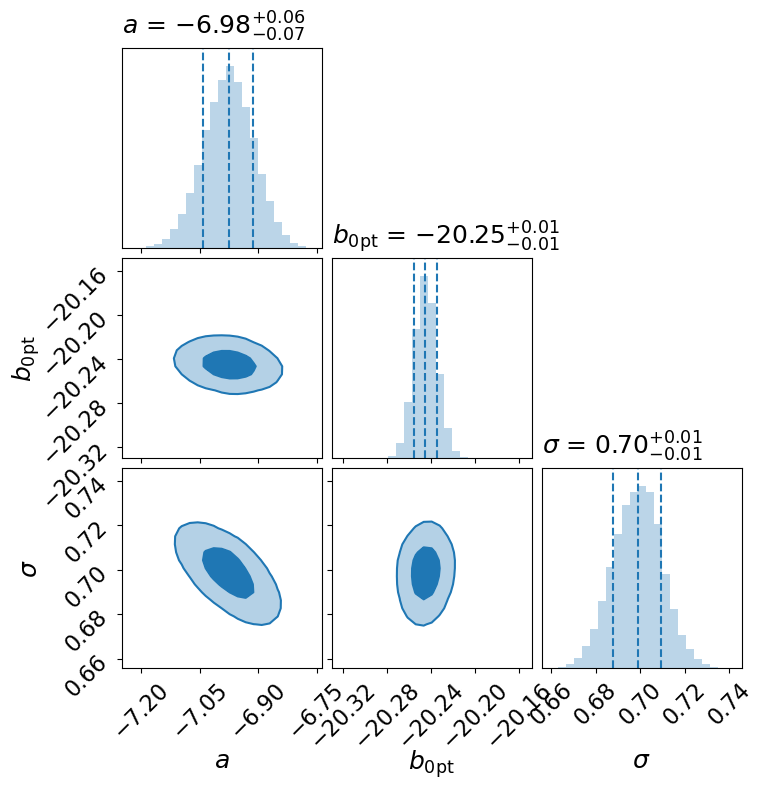

In [26]:
##### Cornerplot with just slope, zero point, and scatter
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]


fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1_williams.png', dpi=150);

In [27]:
# # Read in the pickle file with the fit

# # Open the pickle file and load the data
# with open('cov_ab_jura_jointTFR_varyV0_binaryML_full_sample.pickle', 'rb') as temp_infile:
#     cov_tfr, tfr_mcmc_samples, logV0 = pickle.load(temp_infile)

# # Now the variables cov_tfr, tfr_mcmc_samples, and logV0 are defined and available to use


In [28]:
# fig.savefig('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0.png', dpi=150);

### Plot the HyperFit Results

In [29]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

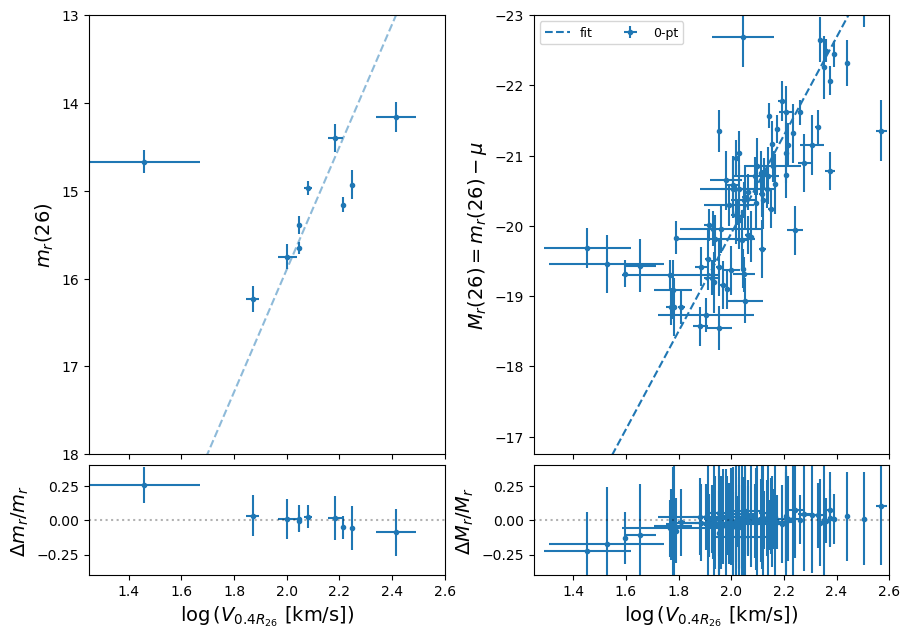

In [30]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', )
                     # label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label='fit')

ax.set(xlim=[1.25, 2.75],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -23])
ax.set_ylabel(r'$M_r(26) = m_r(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('Figures/TF_Y3_cluster_calibration_0pt_binaryML_fit_full_sample.png', dpi=150)

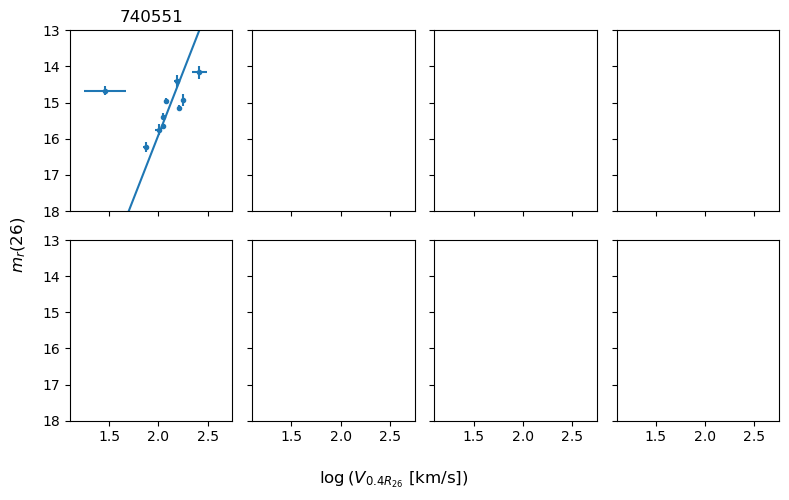

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(8,5), tight_layout=False)

color = iter(plt.get_cmap('tab20').colors)
for i in range(m):
    c = plt.get_cmap('tab20').colors[i % 20]
    
    row = int(i/4)
    col = i%4
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.1, 2.75], ylim=[18, 13], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r (26)$');
# plt.savefig('Figures/Y3_Individual_Cluster_Fits_full_sample.png')

## Check for Dwarf Galaxies

In [32]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

38.475294065808406 km/s


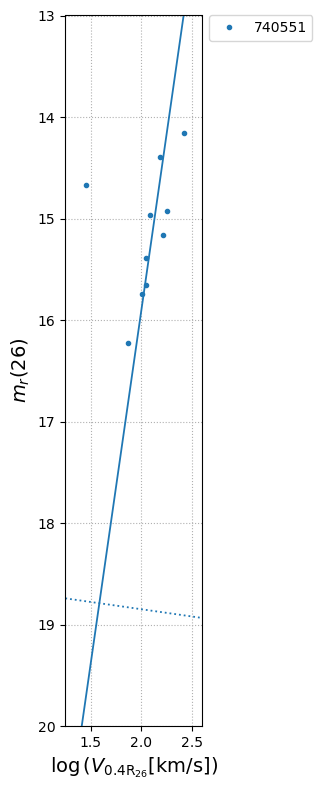

In [33]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

In [34]:
##### Filter out any of these dwarves

dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[i])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
